In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

# for convolutional network
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

from random import shuffle
import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, _), (x_test,_) = mnist.load_data()

In [3]:
# we are going to try to create a jigsaw puzzle from an image. 
# the encoder is going to learn to solve the puzzle


def decompose(image, stride_i=4, stride_j=4):
    '''takes an input image and breaks it up into 4x4 blocks'''
    assert image.shape[0]%stride_i == 0
    assert image.shape[0]%stride_j == 0
    start = 0
    l = []
    for i in range(image.shape[0]//stride_i):
        for j in range(image.shape[1]//stride_j):
            l += [image[(start+stride_i*i):(start+stride_i * (i+1)), 
                         (start + stride_j*j):(start+stride_j*(j+1))]]
    shuffle(l)
    return l

def stitch(shuffled_image):
    '''takes a list of square blocks and assembles into an image'''
    assert np.sqrt(len(shuffled_image)) %1 == 0 # check that shuffled image can be made square
    N = int(np.sqrt(len(shuffled_image)))
    return np.block([shuffled_image[i*N:(i+1)*N] for i in range(N)])

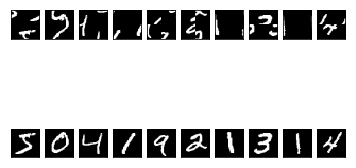

In [4]:
# we can visualize how this does on a sample image
for n in range(10):
    image = x_train[n]
    ax = plt.subplot(2, 10, n+1)
    plt.imshow(stitch(decompose(image, stride_i=14, stride_j=14)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, n+1+10)
    plt.imshow(image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [5]:
# we now construct a convolutional encoder

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x1.shape)
x2 = MaxPooling2D((2, 2), padding='same')(x1)
print(x2.shape)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
print(x3.shape)
x4 = MaxPooling2D((2, 2), padding='same')(x3)
print(x4.shape)
x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
print(x5.shape)
encoded = MaxPooling2D((2, 2), padding='same')(x5)
print(encoded.shape)

# # at this point the representation is (4, 4, 64) i.e. 1024-dimensional

x6 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
print(x6.shape)
x7 = UpSampling2D((2, 2))(x6)
print(x7.shape)
x8 = Conv2D(32, (3, 3), activation='relu', padding='same')(x7)
print(x8.shape)
x9 = UpSampling2D((2, 2))(x8)
print(x9.shape)
x10 = Conv2D(16, (3, 3), activation='relu')(x9)
print(x10.shape)
x11 = UpSampling2D((2, 2))(x10)
print(x11.shape)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x11)
print(decoded.shape)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 7, 7, 64)
(?, 4, 4, 64)
(?, 4, 4, 64)
(?, 8, 8, 64)
(?, 8, 8, 32)
(?, 16, 16, 32)
(?, 14, 14, 16)
(?, 28, 28, 16)
(?, 28, 28, 1)


In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_shuffled = np.array(
    [stitch(decompose(_, stride_i=14, stride_j=14)) for _ in x_train])
x_test_shuffled = np.array(
    [stitch(decompose(_, stride_i=14, stride_j=14)) for _ in x_test])

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_train_shuffled = np.reshape(x_train_shuffled, 
        (len(x_train_shuffled), 28,28,1))
x_test_shuffled = np.reshape(x_test_shuffled, 
        (len(x_test_shuffled), 28,28,1))

In [16]:
def make_plot(images, images_shuffled, model):
    decoded_imgs = model.predict(images_shuffled)
    # encoder_model = Model(input_img, encoded)
    # encoded_imgs = encoder_model.predict(x_test)

    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display puzzle
        ax = plt.subplot(3, n, i + n +1)
        plt.imshow(images_shuffled[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 2*n +1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 72s - loss: 0.2686 - val_loss: 0.2273
Epoch 2/5
60000/60000 [==============================] - 72s - loss: 0.2096 - val_loss: 0.1906
Epoch 3/5
60000/60000 [==============================] - 73s - loss: 0.1822 - val_loss: 0.1726
Epoch 4/5
60000/60000 [==============================] - 72s - loss: 0.1674 - val_loss: 0.1625
Epoch 5/5
60000/60000 [==============================] - 71s - loss: 0.1579 - val_loss: 0.1501


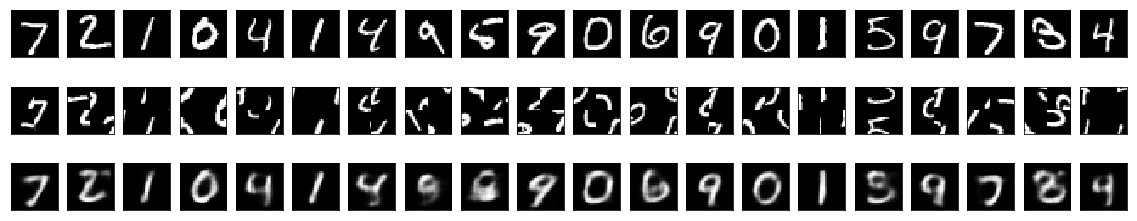

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 71s - loss: 0.1510 - val_loss: 0.1486
Epoch 2/5
60000/60000 [==============================] - 72s - loss: 0.1456 - val_loss: 0.1440
Epoch 3/5
60000/60000 [==============================] - 71s - loss: 0.1415 - val_loss: 0.1384
Epoch 4/5
60000/60000 [==============================] - 72s - loss: 0.1383 - val_loss: 0.1349
Epoch 5/5
60000/60000 [==============================] - 71s - loss: 0.1351 - val_loss: 0.1302


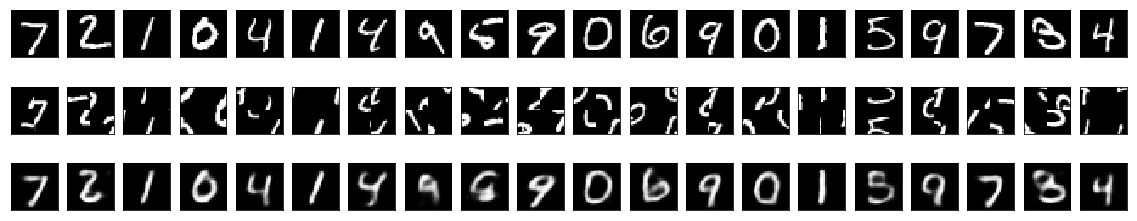

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 69s - loss: 0.1326 - val_loss: 0.1312
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1302 - val_loss: 0.1261
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1282 - val_loss: 0.1300
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1265 - val_loss: 0.1254
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.1248 - val_loss: 0.1214


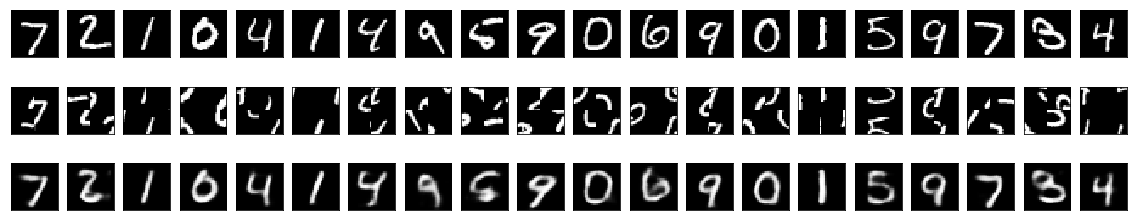

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 68s - loss: 0.1232 - val_loss: 0.1254
Epoch 2/5
60000/60000 [==============================] - 72s - loss: 0.1219 - val_loss: 0.1220
Epoch 3/5
60000/60000 [==============================] - 72s - loss: 0.1207 - val_loss: 0.1227
Epoch 4/5
60000/60000 [==============================] - 72s - loss: 0.1196 - val_loss: 0.1183
Epoch 5/5
60000/60000 [==============================] - 72s - loss: 0.1184 - val_loss: 0.1183


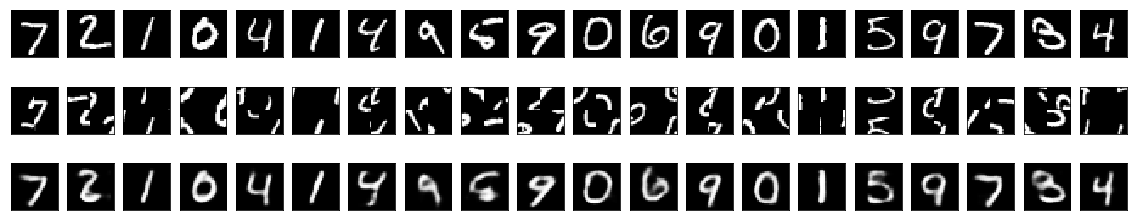

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 70s - loss: 0.1174 - val_loss: 0.1169
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1165 - val_loss: 0.1139
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1157 - val_loss: 0.1150
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1148 - val_loss: 0.1140
Epoch 5/5
60000/60000 [==============================] - 68s - loss: 0.1142 - val_loss: 0.1164


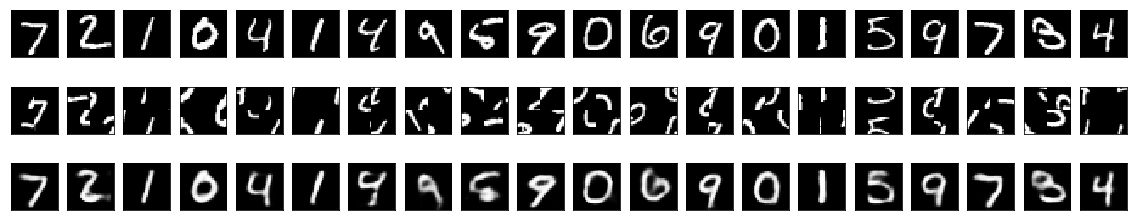

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 68s - loss: 0.1135 - val_loss: 0.1124
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1128 - val_loss: 0.1133
Epoch 3/5
60000/60000 [==============================] - 68s - loss: 0.1122 - val_loss: 0.1127
Epoch 4/5
60000/60000 [==============================] - 68s - loss: 0.1115 - val_loss: 0.1124
Epoch 5/5
60000/60000 [==============================] - 68s - loss: 0.1109 - val_loss: 0.1106


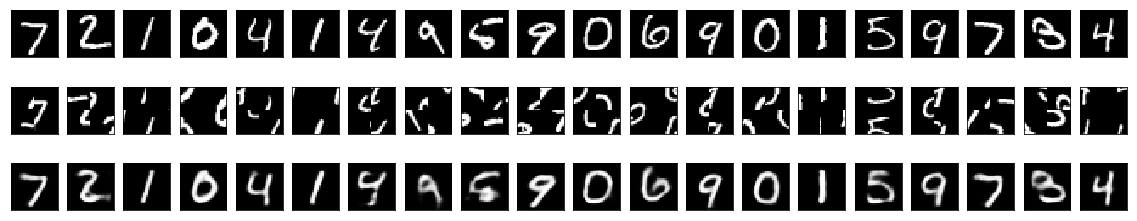

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s - loss: 0.1104 - val_loss: 0.1093
Epoch 2/5
60000/60000 [==============================] - 66s - loss: 0.1098 - val_loss: 0.1097
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1095 - val_loss: 0.1095
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1090 - val_loss: 0.1078
Epoch 5/5
60000/60000 [==============================] - 73s - loss: 0.1084 - val_loss: 0.1104


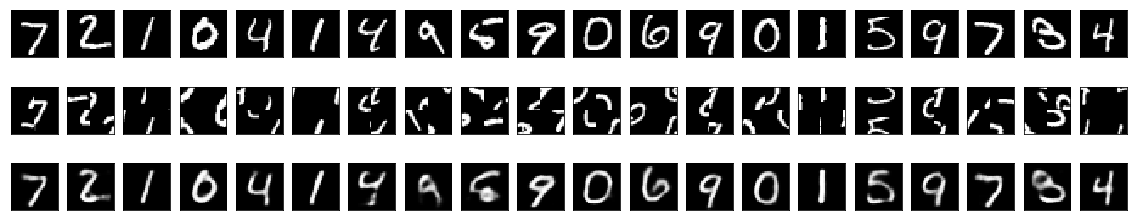

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 75s - loss: 0.1080 - val_loss: 0.1090
Epoch 2/5
60000/60000 [==============================] - 72s - loss: 0.1076 - val_loss: 0.1118
Epoch 3/5
60000/60000 [==============================] - 72s - loss: 0.1072 - val_loss: 0.1072
Epoch 4/5
60000/60000 [==============================] - 71s - loss: 0.1067 - val_loss: 0.1080
Epoch 5/5
60000/60000 [==============================] - 72s - loss: 0.1064 - val_loss: 0.1066


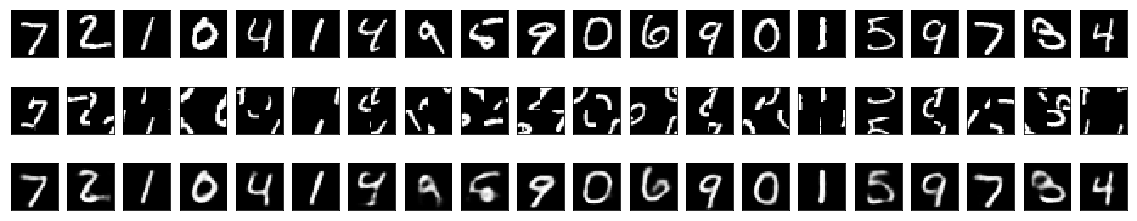

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 70s - loss: 0.1062 - val_loss: 0.1046
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1058 - val_loss: 0.1058
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1054 - val_loss: 0.1065
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1051 - val_loss: 0.1057
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.1048 - val_loss: 0.1047


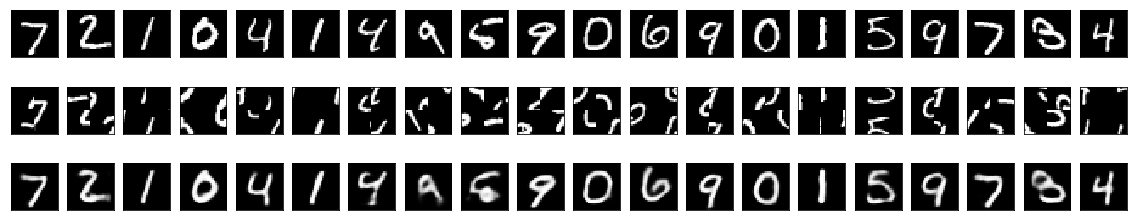

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.1045 - val_loss: 0.1050
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1042 - val_loss: 0.1036
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1039 - val_loss: 0.1051
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1037 - val_loss: 0.1061
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.1035 - val_loss: 0.1033


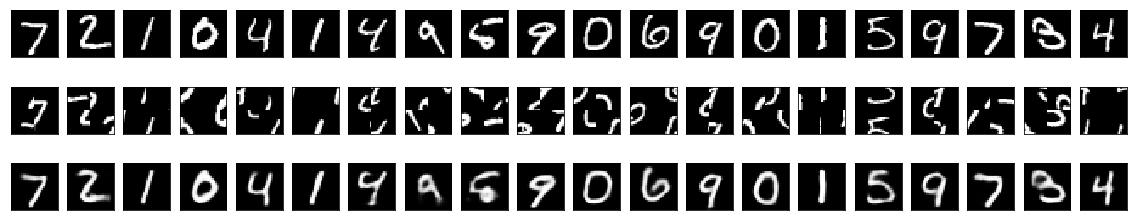

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.1033 - val_loss: 0.1030
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1029 - val_loss: 0.1024
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1027 - val_loss: 0.1036
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1024 - val_loss: 0.1027
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.1021 - val_loss: 0.1017


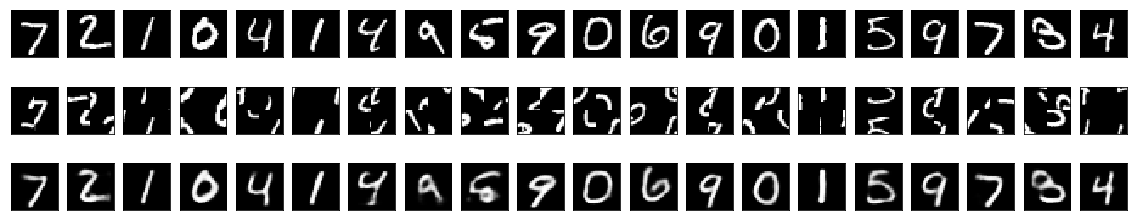

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.1019 - val_loss: 0.1044
Epoch 2/5
60000/60000 [==============================] - 68s - loss: 0.1017 - val_loss: 0.1029
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1014 - val_loss: 0.1028
Epoch 4/5
60000/60000 [==============================] - 66s - loss: 0.1014 - val_loss: 0.1021
Epoch 5/5
60000/60000 [==============================] - 66s - loss: 0.1012 - val_loss: 0.1021


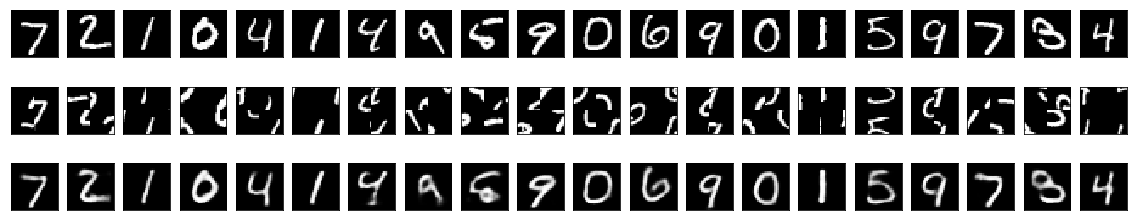

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s - loss: 0.1011 - val_loss: 0.1004
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1007 - val_loss: 0.1019
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.1007 - val_loss: 0.1019
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.1005 - val_loss: 0.1035
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.1004 - val_loss: 0.1014


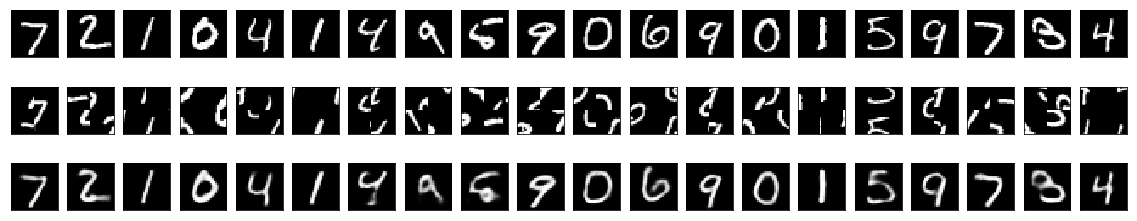

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.1002 - val_loss: 0.0994
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.1000 - val_loss: 0.0989
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.0996 - val_loss: 0.0995
Epoch 4/5
60000/60000 [==============================] - 66s - loss: 0.0996 - val_loss: 0.1008
Epoch 5/5
60000/60000 [==============================] - 66s - loss: 0.0993 - val_loss: 0.0986


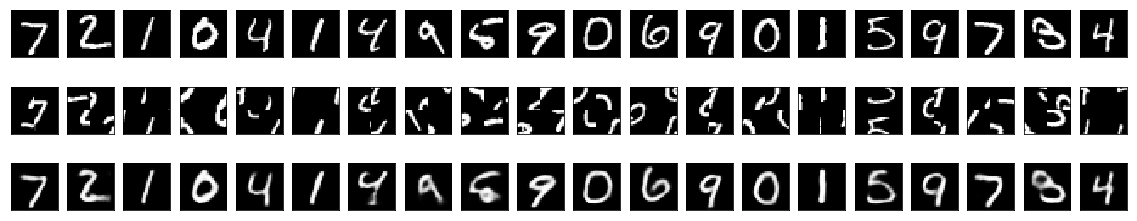

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.0993 - val_loss: 0.1007
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.0991 - val_loss: 0.0995
Epoch 3/5
60000/60000 [==============================] - 66s - loss: 0.0990 - val_loss: 0.0988
Epoch 4/5
60000/60000 [==============================] - 66s - loss: 0.0987 - val_loss: 0.0982
Epoch 5/5
60000/60000 [==============================] - 66s - loss: 0.0986 - val_loss: 0.1003


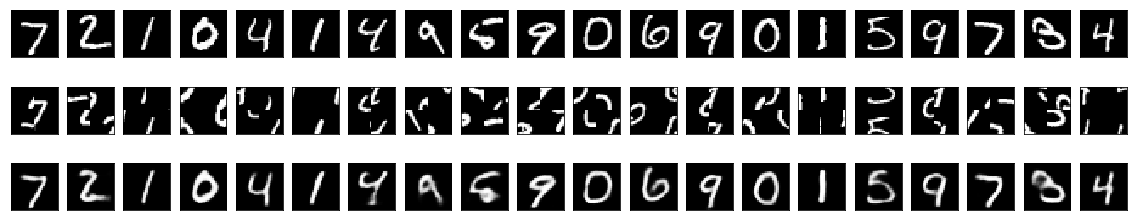

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s - loss: 0.0986 - val_loss: 0.0996
Epoch 2/5
60000/60000 [==============================] - 66s - loss: 0.0985 - val_loss: 0.0998
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.0983 - val_loss: 0.0988
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.0981 - val_loss: 0.0995
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.0981 - val_loss: 0.0977


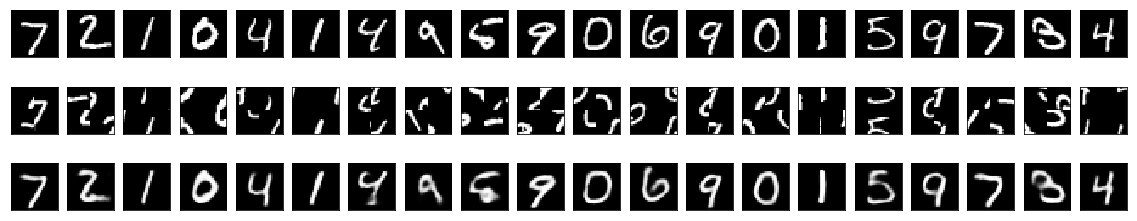

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s - loss: 0.0980 - val_loss: 0.0998
Epoch 2/5
60000/60000 [==============================] - 66s - loss: 0.0978 - val_loss: 0.0986
Epoch 3/5
60000/60000 [==============================] - 66s - loss: 0.0976 - val_loss: 0.0995
Epoch 4/5
60000/60000 [==============================] - 66s - loss: 0.0975 - val_loss: 0.0983
Epoch 5/5
60000/60000 [==============================] - 66s - loss: 0.0973 - val_loss: 0.0997


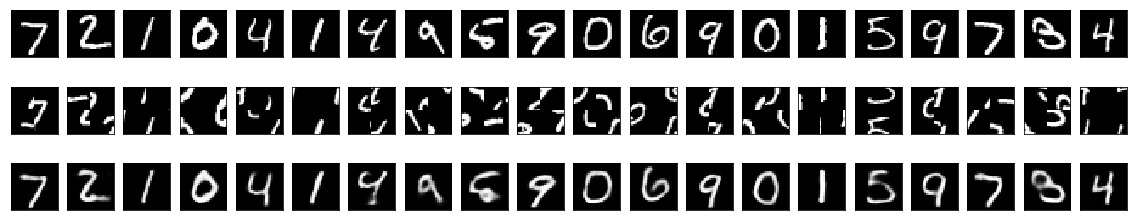

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.0974 - val_loss: 0.0992
Epoch 2/5
60000/60000 [==============================] - 67s - loss: 0.0972 - val_loss: 0.0990
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.0970 - val_loss: 0.0978
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.0970 - val_loss: 0.0981
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.0969 - val_loss: 0.0986


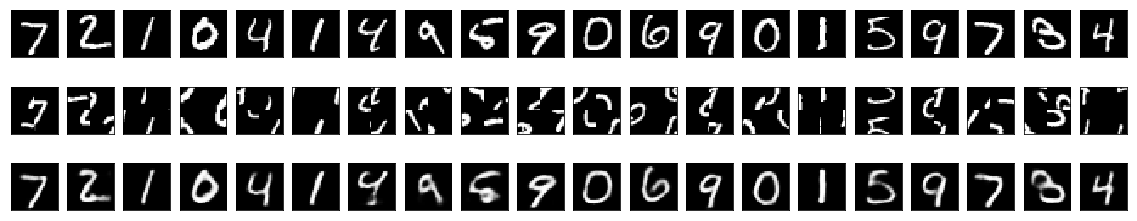

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 66s - loss: 0.0968 - val_loss: 0.0983
Epoch 2/5
60000/60000 [==============================] - 66s - loss: 0.0967 - val_loss: 0.0973
Epoch 3/5
60000/60000 [==============================] - 67s - loss: 0.0965 - val_loss: 0.0973
Epoch 4/5
60000/60000 [==============================] - 67s - loss: 0.0964 - val_loss: 0.0976
Epoch 5/5
60000/60000 [==============================] - 67s - loss: 0.0964 - val_loss: 0.0974


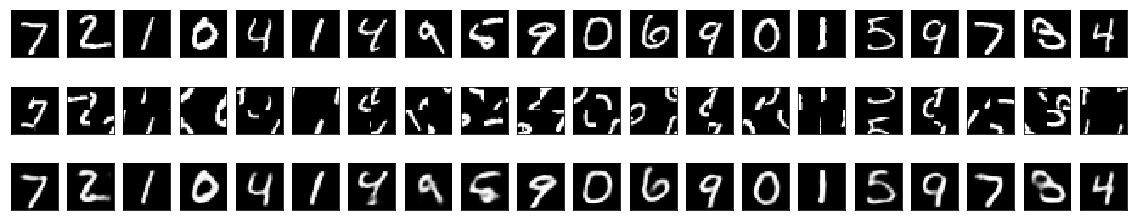

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 67s - loss: 0.0962 - val_loss: 0.0998
Epoch 2/5
60000/60000 [==============================] - 66s - loss: 0.0962 - val_loss: 0.0977
Epoch 3/5
60000/60000 [==============================] - 66s - loss: 0.0961 - val_loss: 0.0958
Epoch 4/5
60000/60000 [==============================] - 66s - loss: 0.0959 - val_loss: 0.0982
Epoch 5/5
60000/60000 [==============================] - 66s - loss: 0.0958 - val_loss: 0.0978


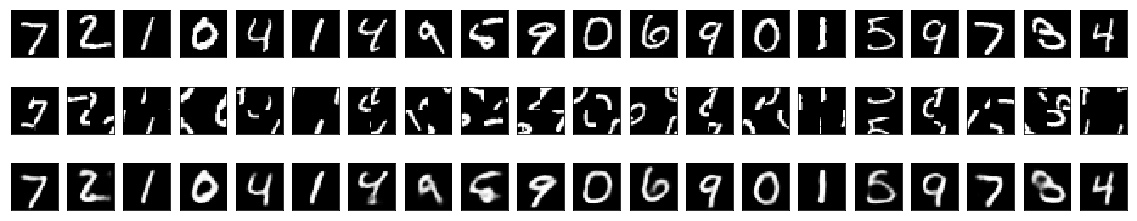

In [8]:
#!tensorboard --logdir=/tmp/autoencoder

for i in range(20):
    autoencoder.fit(x_train_shuffled, x_train,
                 epochs=5,
                 batch_size=128,
                 shuffle=True,
                 validation_data=(x_test_shuffled, x_test),
                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
    make_plot(x_test, x_test_shuffled, autoencoder)

In [10]:
[_.name for _ in autoencoder.layers]

['input_1',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'up_sampling2d_1',
 'conv2d_5',
 'up_sampling2d_2',
 'conv2d_6',
 'up_sampling2d_3',
 'conv2d_7']

In [ ]:
# view encoder activations

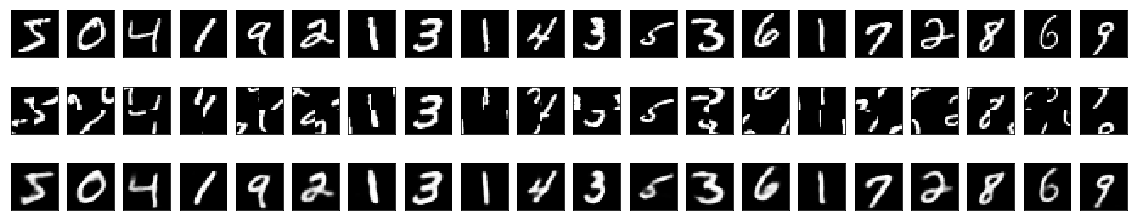

In [32]:
# testing to see if the autoencoder can be recreated by just compiling a
# new model with the same input and output layers

tmp_model = Model(input_img, decoded)
tmp_model.compile(optimizer='adadelta', loss='binary_crossentropy')

tmp_decoded = tmp_model.predict(x_train_shuffled)
make_plot(x_train, x_train_shuffled, tmp_model)

# yes!

In [33]:
# construct a model with the appropriate input and activation layer
tmp_model_2 = Model(input_img, encoded)
tmp_model_2.compile(optimizer='adadelta', loss='binary_crossentropy')
activations = tmp_model_2.predict(x_train_shuffled)

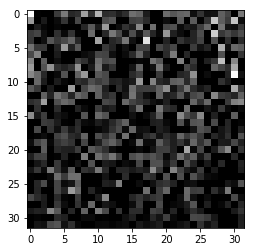

In [130]:
# visualize!
plt.imshow(activations[1].reshape(32,32))
plt.show()

# kind of boring

In [36]:
# find the images which best activate a give filter

from keras import applications

layer_dict = dict([(layer.name, layer) for layer in autoencoder.layers])

In [37]:
layer_dict

{'conv2d_1': <keras.layers.convolutional.Conv2D at 0x7f934d7a42b0>,
 'conv2d_2': <keras.layers.convolutional.Conv2D at 0x7f934d7687f0>,
 'conv2d_3': <keras.layers.convolutional.Conv2D at 0x7f934d6fb7b8>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x7f934d71ef98>,
 'conv2d_5': <keras.layers.convolutional.Conv2D at 0x7f934d6c5668>,
 'conv2d_6': <keras.layers.convolutional.Conv2D at 0x7f934d685a90>,
 'conv2d_7': <keras.layers.convolutional.Conv2D at 0x7f934d632748>,
 'input_1': <keras.engine.topology.InputLayer at 0x7f934d7a4240>,
 'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D at 0x7f934d7a4358>,
 'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D at 0x7f934d768e80>,
 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D at 0x7f934d70ed68>,
 'up_sampling2d_1': <keras.layers.convolutional.UpSampling2D at 0x7f934d6b1ef0>,
 'up_sampling2d_2': <keras.layers.convolutional.UpSampling2D at 0x7f934d6da7f0>,
 'up_sampling2d_3': <keras.layers.convolutional.UpSampling2D at 0x7f934

In [124]:
layer_name = 'max_pooling2d_3'
filter_index = 24  # can be any integer from 0 to 63, as there are 64 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [125]:
# we start from a gray image with some noise
img_width=28
img_height=28
step=1
input_img_data = np.random.random((1,img_width, img_height,1)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(10000):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [126]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    #x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    #x = x.transpose((1, 2, 0))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data
img = deprocess_image(img)
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

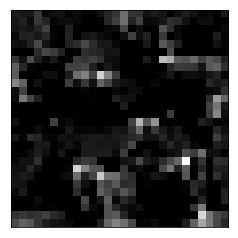

In [127]:
ax = plt.subplot(1, 1, 1)
plt.imshow(img.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()


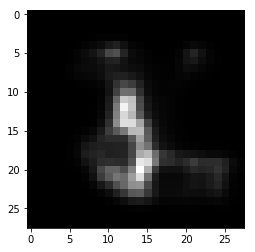

In [128]:
# we take this image and put it through the encoder to see what feature
# is actually encoded by the activated layer
plt.imshow(autoencoder.predict(img).reshape(28,28))
plt.gray()
plt.show()